In [1]:
# IMPORTS
import requests
import json
from sportmonks.soccer import SoccerApiV2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import xlsxwriter
import excel2json
from datetime import datetime
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# JSON FORMAT PRINT
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
# API key
soccer = SoccerApiV2(api_token='kDasthE00jpkFjEERAZNFyE9a79LNX3tPeaAqlhB3s2NhckJbKDhyL94j7AO')

In [4]:
# START AND END DATE 
start_date = "2018-08-10"
# end_date = "2018-08-10"
end_date = "2019-05-12"

# EMPTY LIST FOR ALL THE VARIABLES
lijst = []
sub_list = []
sub_list_min = []

# START QUERY
ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue', 'bench'))

# CHANGE THIS LIST TO THE FEATURES YOU APPED
inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Weather_code', 'Weather_humidity', 'Weather_temp', 'Injured'] 
lijst.append(inhoud)

# FOR LOOP TO GET ALL THE FIXTURES IN BETWEEN THE START AND END DATE
for f in ids:
    team = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
    while len(team) < len(f['lineup']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES (name, position, minutes played, day since start date, injury)
        
        # NAME PLAYER
        name = f['lineup'][index]['player_name']
        team.append(speler)   
    
        # POSITION PLAYER
        position = f['lineup'][index]['position']
        
        # MINUTES PLAYED
        minutes = f['lineup'][index]['stats']['other']['minutes_played']
        if minutes == None:
            continue
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        
        # TOTAL MINUTES PLAYED
        for iets in reversed(lijst):
            if iets[0] == name:
                gespeeld = iets[4]
                total = gespeeld + minutes
                break
            else:
                gespeeld = minutes
                total = gespeeld
        
        # TIMES STARTED IN LINEUP 
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[5]
                lineup_starts = nummer + 1
                break
            else:
                nummer = 0
                lineup_starts = nummer + 1
                
        # TIMES STARTED ON THE BENCH
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[6]
                bench_starts = nummer
                break
            else:
                nummer = 0
                bench_starts = nummer
        
        # VARIABLE FEATURES 
        
        # WEATHER
        if f['weather_report'] != None:
            weather_code = f['weather_report']['code']
            hum = f['weather_report']['humidity']
            humidity = hum[:-1]
            weather_humidity = float(humidity)
            weather_temp = f['weather_report']['temperature']['temp']
        else:
            continue
        
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        
        # INJURY
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1

        
        # APPEND TO THE PLAYER'S LIST
        speler.append(name)
        speler.append(position)
        speler.append(minutes)
        speler.append(delta.days)
        speler.append(total)
        speler.append(lineup_starts)
        speler.append(bench_starts)
        speler.append(weather_code)
        speler.append(weather_humidity)
        speler.append(weather_temp)
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')

        
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1

        
# SUBSTITUTES

    wissels = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
    while len(wissels) < len(f['bench']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES
        
        # NAME PLAYER
        name = f['bench'][index]['player_name']
        wissels.append(speler)   
    
        # POSITION PLAYER
        position = f['bench'][index]['position']
        
        # MINUTES PLAYED
        minutes = f['bench'][index]['stats']['other']['minutes_played']
        if minutes == None:
            minutes = 0
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        
        # TOTAL MINUTES PLAYED
        for iets in reversed(lijst):
            if iets[0] == name:
                if iets[3] < delta.days: 
                    gespeeld = iets[4]
                    total = gespeeld + minutes
                    break
                else:
                    continue
            else:
                gespeeld = minutes
                total = gespeeld

        # TIMES STARTED IN LINEUP 
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[5]
                lineup_starts = nummer
                break
            else:
                nummer = 0
                lineup_starts = nummer
                
        # TIMES STARTED ON THE BENCH
        for iets in reversed(lijst):
            new_name = iets[0].split(' ')[-1]
            check_name = name.split(' ')[-1]
            if new_name == check_name and iets[0][0] == name[0]:
                nummer = iets[6]
                bench_starts = nummer + 1
                break
            else:
                nummer = 0
                bench_starts = nummer + 1        
                
        # VARIABLE FEATURES 
        
        # WEATHER
        if f['weather_report'] != None:
            weather_code = f['weather_report']['code']
            hum = f['weather_report']['humidity']
            humidity = hum[:-1]
            weather_humidity = float(humidity)
            weather_temp = f['weather_report']['temperature']['temp']
        else:
            continue
        
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        
        # INJURY
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1

        
        # APPEND TO THE PLAYER'S LIST
        speler.append(name)
        speler.append(position)
        speler.append(minutes)
        speler.append(delta.days)
        speler.append(total)
        speler.append(lineup_starts)
        speler.append(bench_starts)
        speler.append(weather_code)
        speler.append(weather_humidity)
        speler.append(weather_temp)
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')

        
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1        
        
        
        
        

print(lijst)

[['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Lineup_starts', 'Bench_starts', 'Weather_code', 'Weather_humidity', 'Weather_temp', 'Injured'], ['Diederik Boer', 'G', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Kingsley Ehizibue', 'D', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Darryl Lachman', 'D', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Dirk Marcellis', 'D', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Bram Van Polen', 'D', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Gustavo Hamer', 'M', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Clint Leemans', 'M', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Denis Genreau', 'M', 46, 0, 46, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Zian Flemming', 'M', 87, 0, 87, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Vito van Crooy', 'A', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Mike van Duinen', 'A', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8, 'No'], ['Warner Hahn', 'G', 90, 0, 90, 1, 0, 'clouds', 46.0, 69.8

In [5]:
# CODE TO EXPORT TO EXCEL 
with xlsxwriter.Workbook('ajaxweather.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(lijst):
        worksheet.write_row(row_num, 0, data)

# CODE TO CONVERT EXCEL FILE TO JSON --> (Sheet1.json)
excel2json.convert_from_file('ajaxweather.xlsx')


In [7]:
# READ THE JOSN FILE AND PRINT HEAD
ajax = pd.read_json("Sheet1.json")
print(ajax)

                    Name Position  Minutes_played  Day_since_start  \
0          Diederik Boer        G              90                0   
1      Kingsley Ehizibue        D              90                0   
2         Darryl Lachman        D              90                0   
3         Dirk Marcellis        D              90                0   
4         Bram Van Polen        D              90                0   
...                  ...      ...             ...              ...   
11216       Clint Essers        D               0              275   
11217      Andrija Balić        M              34              275   
11218    Lisandro Semedo        A              26              275   
11219          Agim Zeka        A              14              275   
11220    Lazaros Lamprou        A               0              275   

       Total_minutes Weather_code  Weather_humidity  Weather_temp Injured  
0                 90       clouds                46         69.80      No  
1      

In [8]:
# inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Injuried', 'Venue'] 

le = preprocessing.LabelEncoder()

ajax['Name'] = le.fit_transform(ajax['Name'])
ajax['Position'] = le.fit_transform(ajax['Position'])
ajax['Weather_code'] = le.fit_transform(ajax['Weather_code'])
# ajax['Weather_humidity'] = le.fit_transform(ajax['Weather_humidity'])
# ajax['Weather_temp'] = le.fit_transform(ajax['Weather_temp'])
ajax['Injured'] = le.fit_transform(ajax['Injured'])

In [9]:
Y = ajax.Injured
X = ajax.drop('Injured', axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [11]:
classifier = DecisionTreeClassifier(random_state=0, max_depth=None)
classifier.fit(X_train_val, y_train_val)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [12]:
# PREDICT VALIDATION
y_pred = classifier.predict(X_val)

In [13]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_val, y_pred))

0.9916481069042317


In [14]:
# # TRANSFORM LABELS BACK TO ORIGINAL ENCODING
# print(ajax['Injured'])
ajax['Injured'] = le.inverse_transform(ajax['Injured'])
# print(ajax['Injured'])

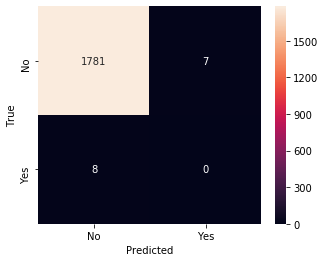

In [15]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion = pd.DataFrame(confusion_matrix(y_val, y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# PREDICT TEST 
y_pred = classifier.predict(X_test)

In [17]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_test, y_pred))

0.9861915367483296


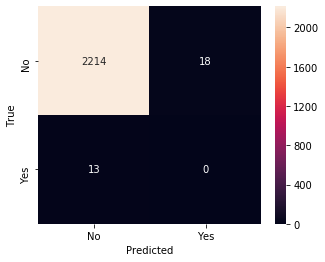

In [18]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

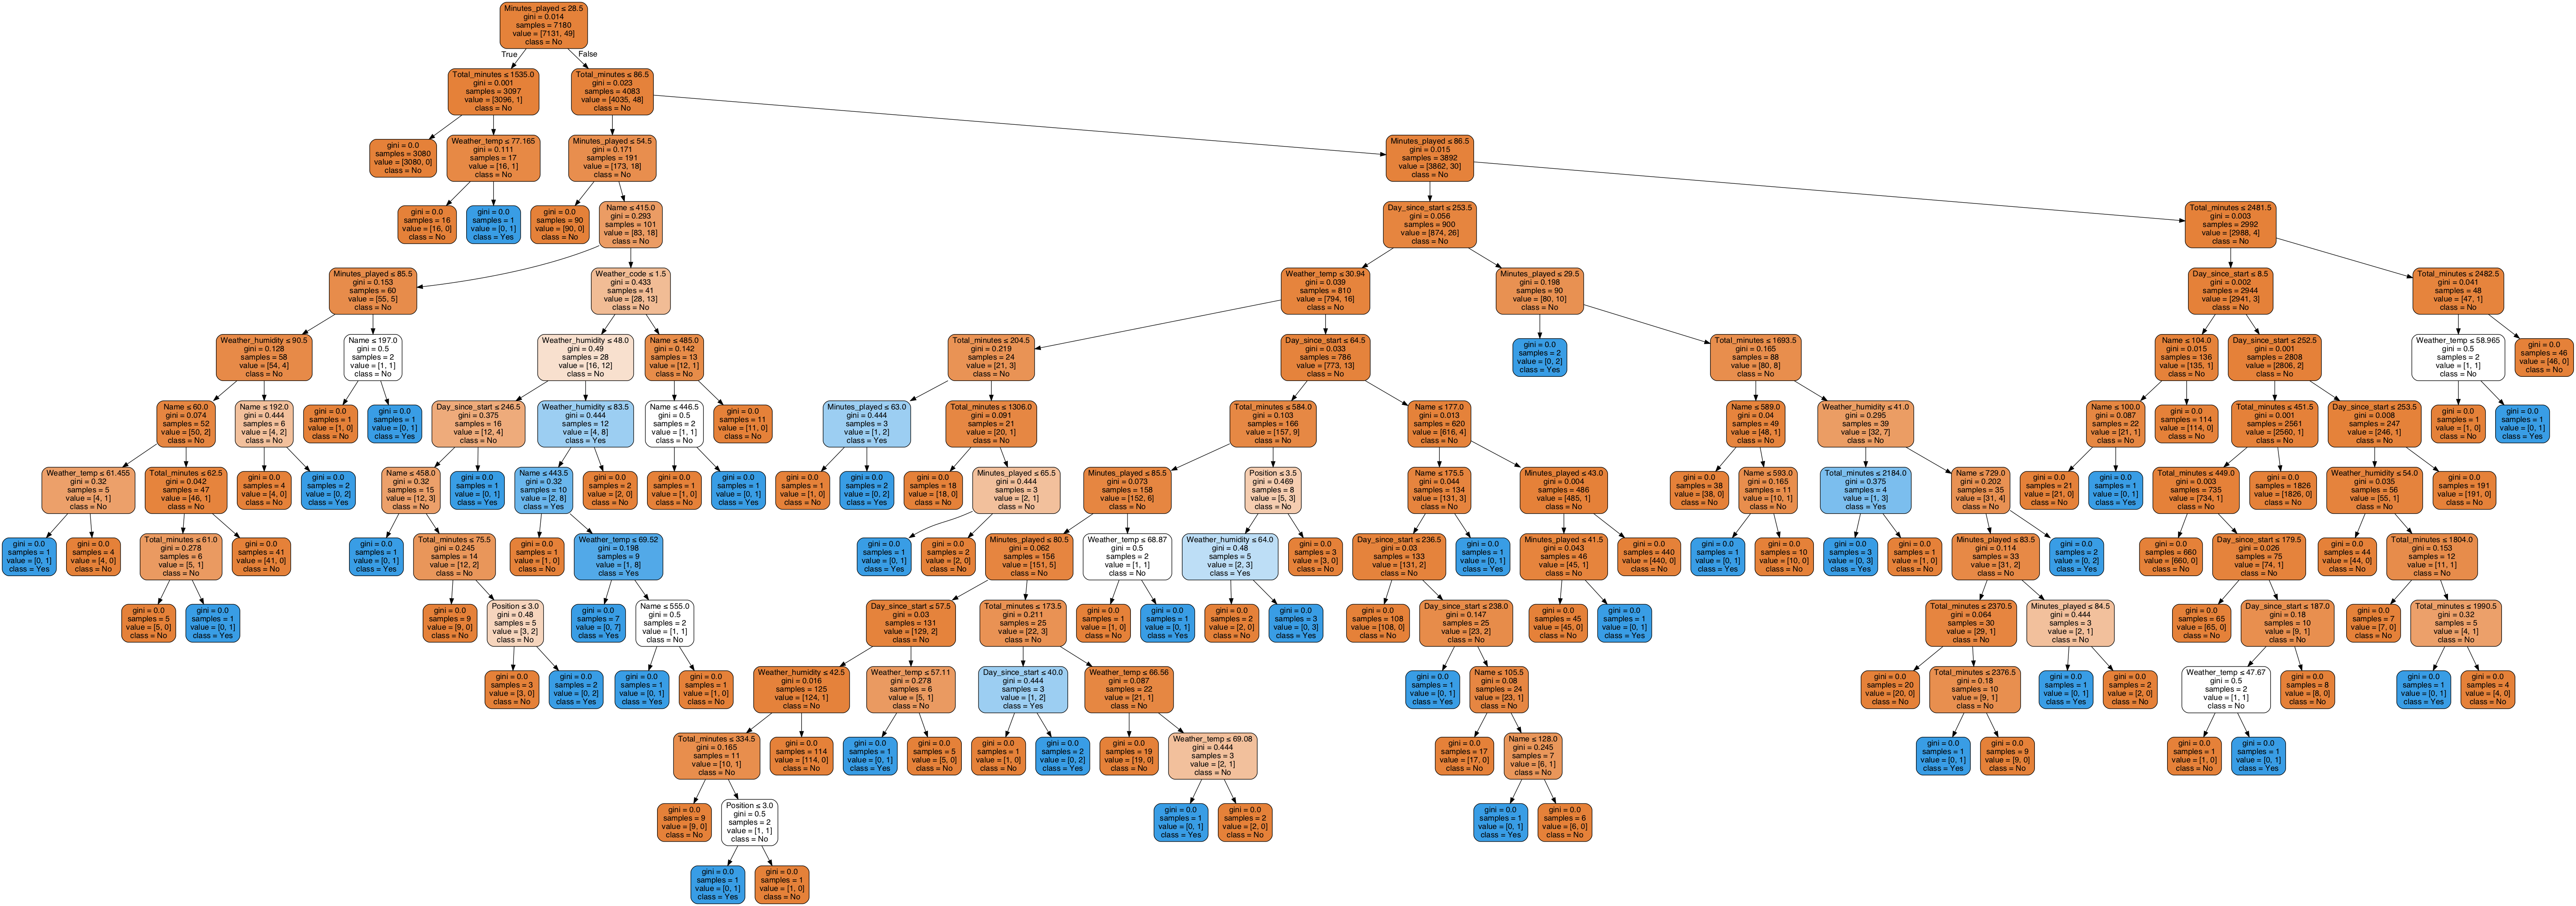

In [20]:
feature_cols = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Total_minutes', 'Weather_code', 'Weather_humidity', 'Weather_temp'] 

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols, class_names=['No','Yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('predictions.png')
Image(graph.create_png())

In [87]:
# start_date = "2018-08-10"
# end_date = "2018-08-10"

# ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue'))

# for f in ids:
#     print(type(f['weather_report']['temperature']['temp']))